In [1]:
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Input, Conv2DTranspose, concatenate, MaxPooling2D, Conv2D
from keras import backend as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from cv2 import imread
import cv2
import os
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
'''Подключаем Google диск
Для ускорения процесса загрузки файлы были предварительно скачен, размер изображения уменьшен до 256 x 256 точек.'''
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Указываем пути
path_images = '/content/drive/MyDrive/nxr_png/'
path_mask = '/content/drive/MyDrive/mask/'
images = os.listdir(path_images)
mask = os.listdir(path_mask)

In [4]:
# Изначально была мысль разделить файлы по источникам
mask_train = [el for el in mask if el.startswith('CHN')]
mask_test = list(set(mask).difference(mask_train))

In [5]:
# Функция для загрузки и предварительно обработки изображений.
def make_set(mask):
  original, segments = [], []
  for el in mask:
    i = cv2.imread(os.path.join(path_images, el))[:,:,0]
    i = (i.astype('float32')-127.5)/127.5
    m = cv2.imread(os.path.join(path_mask, el))[:,:,0]
    m = m.astype('float32')
    original.append(i)
    segments.append(m)
  return original, segments

In [6]:
x_train, y_train = make_set(mask_train)
x_test, y_test = make_set(mask_test)

In [32]:
# Посмотрим на изображения
def plotMask(original, segments):
    sample = []

    for i in range(6):
        left = original[20+i]
        right = (segments[20+i]-127.5)/127.5
        combined = np.hstack((left,right))
        sample.append(combined)

    plt.figure(figsize=(25,10))

    for i in range(1,7):
      plt.subplot(2,3,i)
      plt.imshow(sample[i-1])
    plt.show()

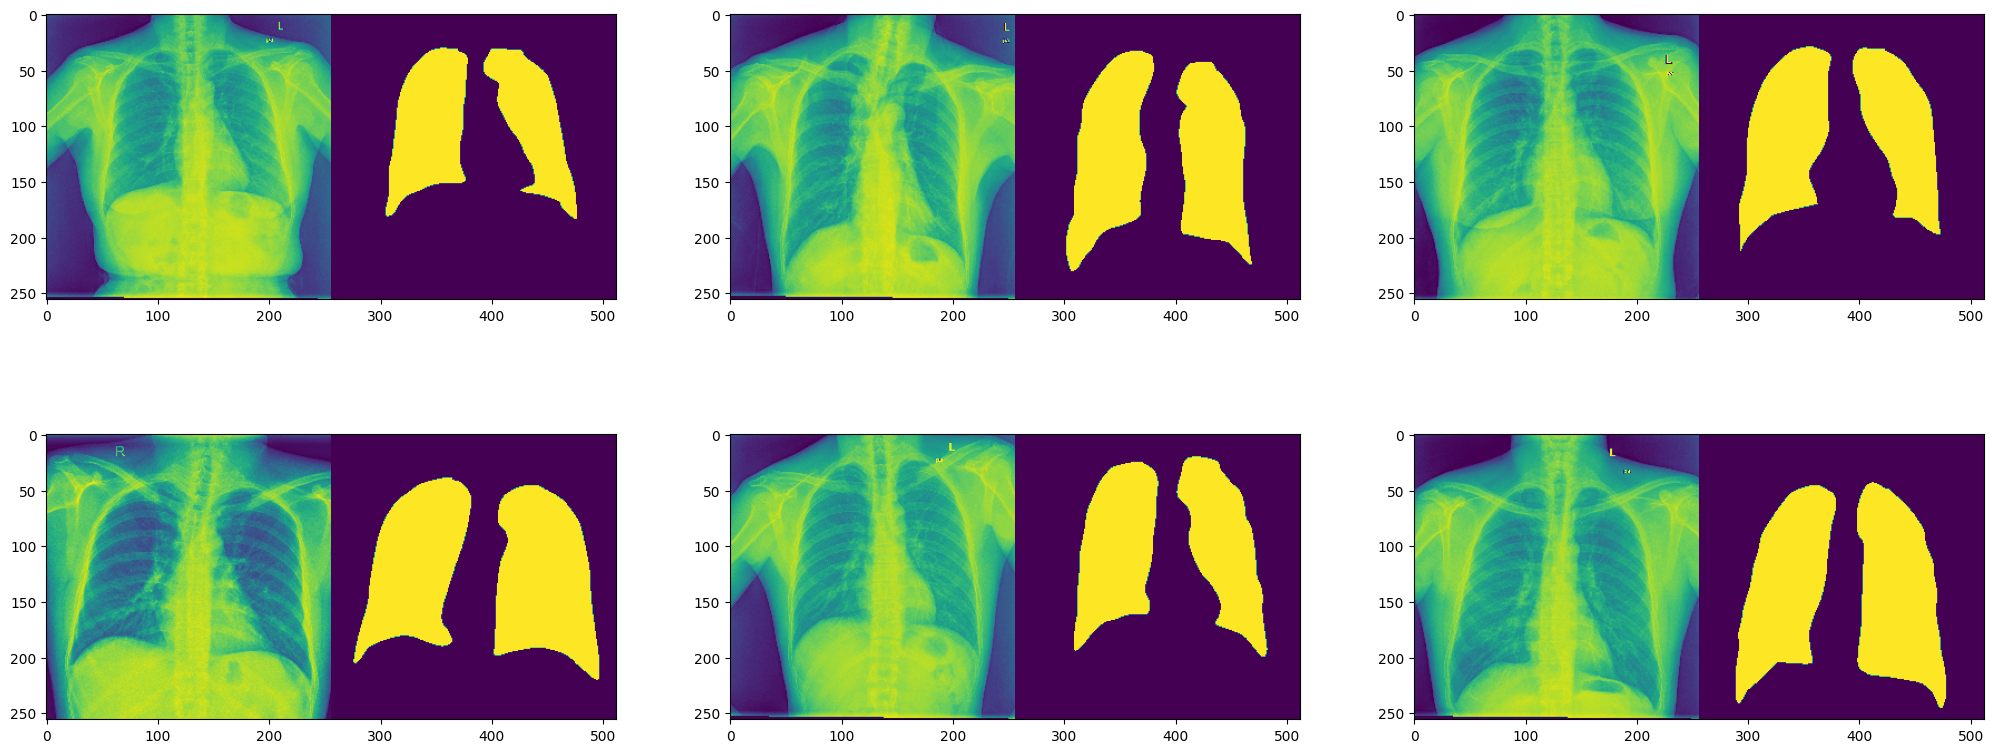

In [33]:
# На мой взгляд маски изображений выполнены не всегда корректно, На одних изображения очертания повторяют только темные части органов, на других полностью контуры.
plotMask(x_train, y_train)

In [7]:
print(x_train[0].shape, y_train[0].shape, x_test[0].shape, y_test[0].shape)
size = x_train[0].shape

(256, 256) (256, 256) (256, 256) (256, 256)


In [8]:
# Переведем наши наборы в 4х мерные тензоры
x_train = np.array(x_train).reshape(len(x_train),size[0],size[1],1)
y_train = np.array(y_train).reshape(len(y_train),size[0],size[1],1)
x_test = np.array(x_test).reshape(len(x_test),size[0],size[1],1)
y_test = np.array(y_test).reshape(len(y_test),size[0],size[1],1)
x_train.shape

(566, 256, 256, 1)

In [9]:
x = np.concatenate((x_test, x_train), axis=0)
y = np.concatenate((y_test, y_train), axis=0)

In [10]:
# В итоге все же решил объединить наборы и разделить уже смешанные.
train_vol, validation_vol, train_seg, validation_seg = train_test_split(x, (y>127).astype('float32'), test_size = 0.1, random_state = 5)

In [13]:
# Dice коэффициент и подсмотрел еще функцию потерь на основе коэфициента
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [14]:
'''Собираем сеть. Основа модель Unet показанная на уроке.
Я отказался от идеи включить слои от предварительно претренированной модели.
И немного упростил модель.'''
def Unet(input_shape=(256, 256, 1)):

  img_input = Input(input_shape) # вход модели

  # Block 1
  x = Conv2D(32, (3,3), padding = 'same', activation='relu', name='block1_conv1')(img_input)
  block_1_out = Conv2D(32, (3,3), padding = 'same', activation='relu', name='block1_conv2')(x)
  x = MaxPooling2D()(block_1_out) # 128x128

  # Block 2
  x = Conv2D(64, (3,3), padding='same', activation='relu', name='block2_conv1')(x)
  block_2_out = Conv2D(64, (3,3), padding='same', activation='relu', name='block2_conv2')(x)
  x = MaxPooling2D()(block_2_out) # 64x64

  # Block 3
  x = Conv2D(128, (3,3), padding='same', activation='relu', name='block3_conv1')(x)
  block_3_out = Conv2D(128, (3,3), padding='same', activation='relu', name='block3_conv2')(x)
  x = MaxPooling2D()(block_3_out) # 32x32

  # Block 4
  x = Conv2D(256, (3,3), padding='same', activation='relu', name='block4_conv1')(x)
  block_4_out = Conv2D(256, (3,3), padding='same', activation='relu', name='block4_conv2')(x)
  x = MaxPooling2D()(block_4_out) # 16x16

  # Block5
  x = Conv2D(512, (3,3), padding='same', activation='relu', name='block5_conv1')(x)
  x = Conv2D(512, (3,3), padding='same', activation='relu', name='block5_conv2')(x)

  # UP 1
  x = Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(x) #32x32
  x = concatenate([x, block_4_out], axis=3)
  x = Conv2D(256, (3,3), padding='same', activation='relu')(x)
  x = Conv2D(256, (3,3), padding='same', activation='relu')(x)

  # UP 2
  x = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(x) # 64x64
  x = concatenate([x, block_3_out])
  x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
  x = Conv2D(128, (3,3), padding='same', activation='relu')(x)

  # UP 3
  x = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(x) # 128x128
  x = concatenate([x, block_2_out])
  x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
  x = Conv2D(64, (3,3), padding='same', activation='relu')(x)

  # UP 4
  x = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(x) # 256x256
  x = concatenate([x, block_1_out])
  x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
  x = Conv2D(32, (3,3), padding='same', activation='relu')(x)


  # слой классификатор
  x = Conv2D(1, (1,1), activation='sigmoid', padding='same')(x)

  model = Model(img_input, x)

  return model

In [15]:
# Callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=3,
                              verbose=1,
                              mode='min',
                              min_delta=0.0001,
                              cooldown=2,
                              min_lr=1e-6)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=15)
callbacks_list = [early, reduce_lr]

In [16]:
# Собираем компилируем и обучаем модель.
model = Unet((256, 256, 1))
model.compile(optimizer=Adam(learning_rate=0.00002), loss=dice_coef_loss, metrics=[dice_coef, 'binary_accuracy'])
history = model.fit(train_vol, train_seg, epochs=50, batch_size=16, validation_data=(validation_vol, validation_seg))

Epoch 1/50
40/40 [==============================] - 38s 472ms/step - loss: -0.3563 - dice_coef: 0.3566 - binary_accuracy: 0.6656 - val_loss: -0.3683 - val_dice_coef: 0.3675 - val_binary_accuracy: 0.6994
Epoch 2/50
40/40 [==============================] - 10s 254ms/step - loss: -0.3590 - dice_coef: 0.3592 - binary_accuracy: 0.6849 - val_loss: -0.3732 - val_dice_coef: 0.3727 - val_binary_accuracy: 0.6991
Epoch 3/50
40/40 [==============================] - 11s 264ms/step - loss: -0.3765 - dice_coef: 0.3774 - binary_accuracy: 0.5652 - val_loss: -0.4596 - val_dice_coef: 0.4591 - val_binary_accuracy: 0.2884
Epoch 4/50
40/40 [==============================] - 11s 267ms/step - loss: -0.4736 - dice_coef: 0.4739 - binary_accuracy: 0.4475 - val_loss: -0.5210 - val_dice_coef: 0.5193 - val_binary_accuracy: 0.6270
Epoch 5/50
40/40 [==============================] - 11s 268ms/step - loss: -0.5659 - dice_coef: 0.5672 - binary_accuracy: 0.7609 - val_loss: -0.7178 - val_dice_coef: 0.7150 - val_binary_ac

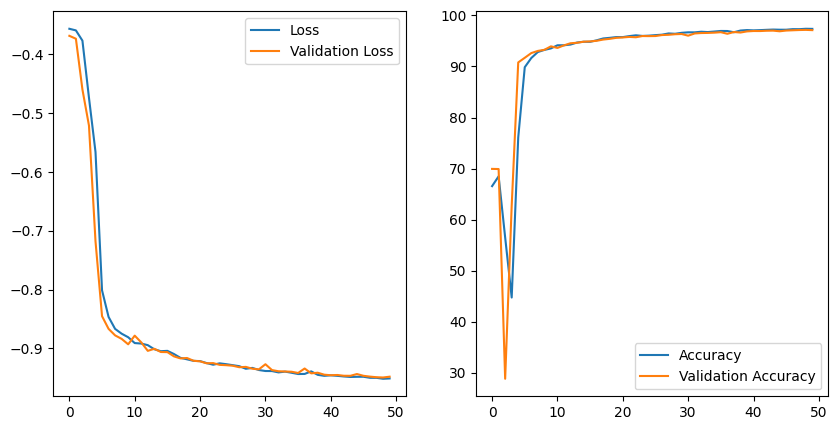

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(history.history['loss'], '-', label = 'Loss')
ax1.plot(history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()
ax2.plot(100*np.array(history.history['binary_accuracy']), '-',
         label = 'Accuracy')
ax2.plot(100*np.array(history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

3/3 [==============================] - 0s 170ms/step


Text(0.5, 0, 'Right - Image, Middle - True Mask, Left - Prediction')

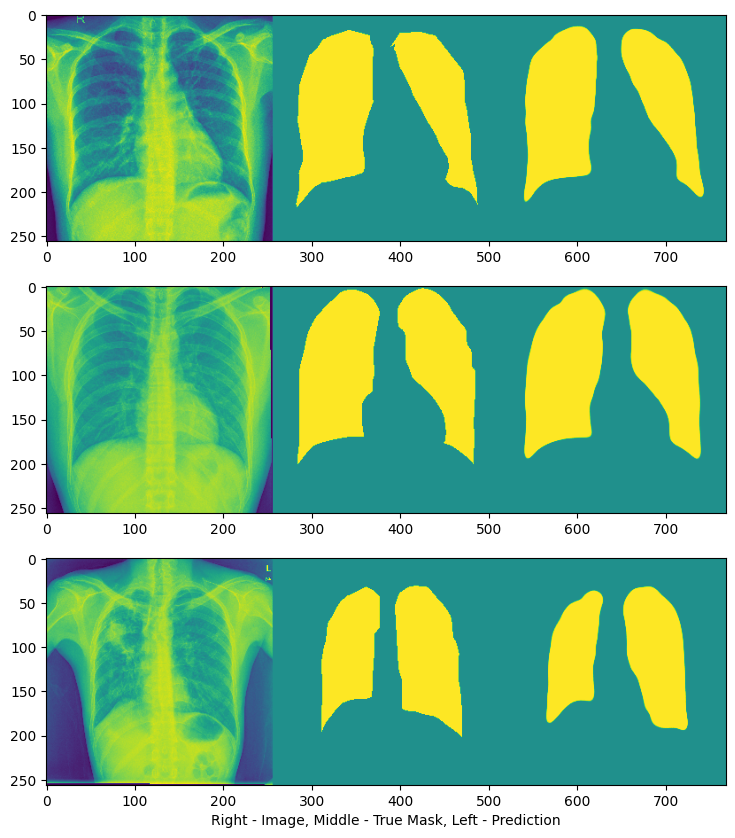

In [23]:
# Посмотрим на результаты предсказаний.
candidates = np.random.randint(1,validation_vol.shape[0],3)
preds = model.predict(validation_vol)
sample = []

for i in candidates:
    left = validation_vol[i]
    middle = validation_seg[i]
    right = preds[i]
    combined = np.hstack((left,middle, right))
    sample.append(combined)

plt.figure(figsize=(25,10))

for i in range(3):
  plt.subplot(3,1,1+i)
  plt.imshow(sample[i])

plt.xlabel('Right - Image,    Middle - True Mask,     Left - Prediction')


In [35]:
# Сохраним веса.
weight_path = '/content/drive/MyDrive/medical_weight.h5'
model.save_weights(weight_path)

Выводы:
- В обучении помогло понимание структуры работы сети;
- Приведение изображений к формату маски 1 слой (черно-белый);
- Подбор количества нейронов сети;
- Подбор гиперпараметров модели.